# Pancreatic cancer

Model based on Vundavilli et al. 2020 https://ieeexplore.ieee.org/document/8476214

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import sys
# import booleanNetwork module from ./src
from BNMPy import booleanNetwork as bn
from BNMPy import BMatrix  

## Loading the model

In [2]:
file = 'input_files/pancreatic_vundavilli_2020_fig3.txt' # Source from PMID: 30281473 DOI: 10.1109/TCBB.2018.2872573

equations = BMatrix.get_equations(file)
gene_dict = BMatrix.get_gene_dict(equations)
upstream_genes = BMatrix.get_upstream_genes(equations)

In [3]:
with open(file) as f:
    file_data = f.read()

In [4]:
%%time

network = BMatrix.load_network_from_file(file)
 # create a Boolean network object
noise_level = 0.05 # noise
y = network.update_noise ( noise_level  , 2000) # simulation with noise

No initial state provided, using a random initial state
CPU times: user 153 ms, sys: 13.3 ms, total: 166 ms
Wall time: 169 ms


In [5]:
y.shape

(2001, 38)

In [6]:
y

array([[1, 1, 1, ..., 0, 1, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 0, 0, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 1, 1],
       [1, 0, 0, ..., 1, 1, 1]], dtype=int8)

## Replicating paper

Input = [PTEN, LKB1, EGF, HBEGF, IGF, NRG1]

Output = [CCND1, BCL2, SRF-ELK1, FOS-JUN, SRF-ELK4, SP1]

If outputs are all 0, then this is a lack of cell proliferation and a non-suppression of apoptosis. A network without faults will produce a 0 output. However, a network with faults will produce a nonzero output vector, leading to a proliferative state.

Drug = [Cryptotanshinone, LY294002, Temsirolimus, Lapatinib, HO-3867]

Faults for every node/gene - they can be either stuck at 0 or stuck at 1.

"Size Difference" metric = (differences/total entries)^2 (just the square of the hamming distance?)

For each fault, and each drug, we calculate the output.

I'm not sure what the input is used for these runs?

Original code for paper: https://github.com/hashwanthvv/boolean/blob/master/pancreatic_one_fault.m

In [13]:
input_genes = ['PTEN', 'LKB1', 'EGF', 'HBEGF', 'IGF', 'NRG1']
output_genes = ['CCND1', 'BCL2', 'SRFELK1', 'FOS-JUN', 'SRFELK4', 'SP1']
# stuck at 0 faults
fault_genes_0 = set(['TSC1/2', 'BAD', 'GSK3'])
# stuck at 1 faults
fault_genes = [g for g in network.nodeDict.keys() if g not in input_genes and g not in output_genes]


In [14]:
# TODO: add faults/mutations?
# for all inputs, 
# 1. set inputs
network.setInitialValue('PTEN', 1)
network.setInitialValue('LKB1', 1)
network.setInitialValue('EGF', 0)
network.setInitialValue('HBEGF', 0)
network.setInitialValue('IGF', 0)
network.setInitialValue('NRG1', 0)


In [15]:
results = network.update(10)

In [16]:
output_baseline_results = [results[-1, network.nodeDict[k]] for k in output_genes]

In [17]:
output_baseline_results

[0, 0, 0, 0, 0, 0]

The baseline results should be all 0s.

### No Drug

In [18]:
all_results = []
for i, g1 in enumerate(fault_genes):
    print(i, g1)
    for j, g2 in enumerate(fault_genes[i+1:]):
        for g in fault_genes[j+1:]:
            network.undoKnockouts()
            network.setInitialValue('PTEN', 1)
            network.setInitialValue('LKB1', 1)
            network.setInitialValue('EGF', 0)
            network.setInitialValue('HBEGF', 0)
            network.setInitialValue('IGF', 0)
            network.setInitialValue('NRG1', 0)
            if g in fault_genes_0:
                network.knockout(g, 0)
            else:
                network.knockout(g, 1)
            if g1 in fault_genes_0:
                network.knockout(g1, 0)
            else:
                network.knockout(g1, 1)
            if g2 in fault_genes_0:
                network.knockout(g2, 0)
            else:
                network.knockout(g2, 1)
            results = network.update(27)
            output = [results[-1, network.nodeDict[k]] for k in output_genes]
            all_results.append(output)
            network.undoKnockouts()

0 EGFR
1 EFGR
2 IGFR1A_B
3 ERBB2
4 JAK5
5 STAT3
6 IRS1
7 GRB2
8 RAS
9 MEKK1
10 RAF
11 MKK4
12 MEK1
13 PIK3CA
14 JNK1
15 ERK1_2
16 PIP3
17 PDPK1
18 AKT1
19 AMPK
20 GSK3
21 TSC1_2
22 RHEB
23 mTOR
24 RPS6KB1
25 BAD


In [19]:
all_results = np.array(all_results)

In [24]:
# calculate size difference without treatment
size_difference = all_results.sum(1)**2/6**2

(array([1129.,  646.,  425.,    0.,  662.,    0., 1988.,    0.,    0.,
         675.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

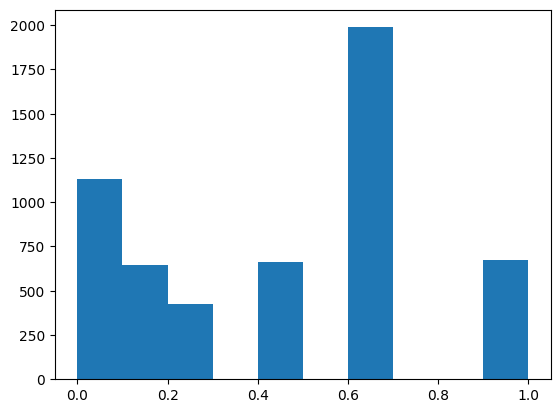

In [25]:
import matplotlib.pyplot as plt
plt.hist(size_difference)

### Single drug effects

In [58]:
drugs = ['Untreated', 'Cryptotanshinone', 'LY294002', 'Temsirolimus', 'Lapatinib', 'HO-3867']
drug_knockouts = {'Cryptotanshinone': ['STAT3', 'ERK1_2'],
                  'LY294002': ['PIK3CA'],
                  'Temsirolimus': ['mTOR'], 
                  'Lapatinib': ['EGFR', 'EFGR', 'ERBB2'],
                  'HO-3867': ['STAT3'],
                  'Untreated': []
                 }

In [29]:
# single-drug combinations
# faults for each drug
all_results_single_drug = {d: [] for d in drugs}
all_results_double_drug = {}
for i, g1 in enumerate(fault_genes):
    print(i, g1)
    for j, g2 in enumerate(fault_genes[i+1:]):
        for g in fault_genes[j+1:]:
            for d in drugs:
                network.undoKnockouts()
                network.setInitialValue('PTEN', 1)
                network.setInitialValue('LKB1', 1)
                network.setInitialValue('EGF', 0)
                network.setInitialValue('HBEGF', 0)
                network.setInitialValue('IGF', 0)
                network.setInitialValue('NRG1', 0)
                if g in fault_genes_0:
                    network.knockout(g, 0)
                else:
                    network.knockout(g, 1)
                if g1 in fault_genes_0:
                    network.knockout(g1, 0)
                else:
                    network.knockout(g1, 1)
                if g2 in fault_genes_0:
                    network.knockout(g2, 0)
                else:
                    network.knockout(g2, 1)
                # set drug effects
                for ko in drug_knockouts[d]:
                    network.knockout(ko, 0)
                results = network.update(27)
                output = [results[-1, network.nodeDict[k]] for k in output_genes]
                all_results_single_drug[d].append(output)
                network.undoKnockouts()

0 EGFR
1 EFGR
2 IGFR1A_B
3 ERBB2
4 JAK5
5 STAT3
6 IRS1
7 GRB2
8 RAS
9 MEKK1
10 RAF
11 MKK4
12 MEK1
13 PIK3CA
14 JNK1
15 ERK1_2
16 PIP3
17 PDPK1
18 AKT1
19 AMPK
20 GSK3
21 TSC1_2
22 RHEB
23 mTOR
24 RPS6KB1
25 BAD


In [35]:
size_differences_single_drug = {}
size_differences_single_drug['Untreated'] = size_difference
for k, v in all_results_single_drug.items():
    v = np.array(v)
    size_differences_single_drug[k] = v.sum(1)**2/6**2


In [36]:
size_differences_single_drug = pd.DataFrame(size_differences_single_drug)

Text(0, 0.5, 'Size difference (Hamming distance^2)')

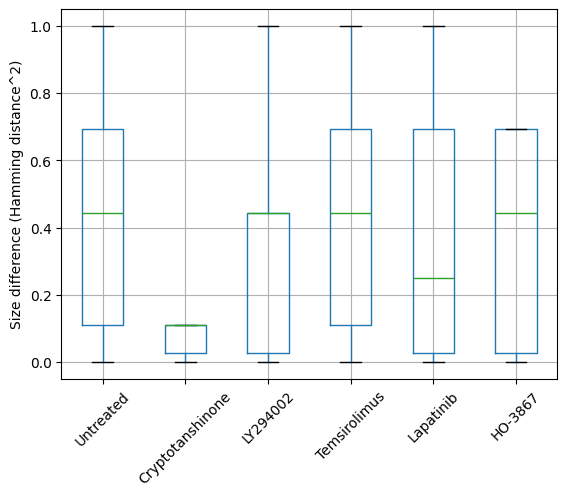

In [41]:
ax = size_differences_single_drug.boxplot()
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Size difference (Hamming distance^2)')


This looks pretty much the same as Fig. 5 in the paper (minus multi-drug combinations). Although, this is triple mutants only. No single and double mutants here.

### Replicating Fig. 5

In [61]:
import itertools
double_drugs = list(itertools.combinations([d for d in drugs if d != 'Untreated'], 2))

In [62]:
list(double_drugs)

[('Cryptotanshinone', 'LY294002'),
 ('Cryptotanshinone', 'Temsirolimus'),
 ('Cryptotanshinone', 'Lapatinib'),
 ('Cryptotanshinone', 'HO-3867'),
 ('LY294002', 'Temsirolimus'),
 ('LY294002', 'Lapatinib'),
 ('LY294002', 'HO-3867'),
 ('Temsirolimus', 'Lapatinib'),
 ('Temsirolimus', 'HO-3867'),
 ('Lapatinib', 'HO-3867')]

In [63]:
# single-fault mutations
single_fault_results_single_drug = {d: [] for d in drugs}
single_fault_results_double_drug = {d: [] for d in double_drugs}
for i, g in enumerate(fault_genes):
    print(i, g)
    for d in drugs:
        network.undoKnockouts()
        network.setInitialValue('PTEN', 1)
        network.setInitialValue('LKB1', 1)
        network.setInitialValue('EGF', 0)
        network.setInitialValue('HBEGF', 0)
        network.setInitialValue('IGF', 0)
        network.setInitialValue('NRG1', 0)
        if g in fault_genes_0:
            network.knockout(g, 0)
        else:
            network.knockout(g, 1)
        # set drug effects
        for ko in drug_knockouts[d]:
            network.knockout(ko, 0)
        results = network.update(27)
        output = [results[-1, network.nodeDict[k]] for k in output_genes]
        single_fault_results_single_drug[d].append(output)
        network.undoKnockouts()
    for d1, d2 in double_drugs:
        network.undoKnockouts()
        network.setInitialValue('PTEN', 1)
        network.setInitialValue('LKB1', 1)
        network.setInitialValue('EGF', 0)
        network.setInitialValue('HBEGF', 0)
        network.setInitialValue('IGF', 0)
        network.setInitialValue('NRG1', 0)
        if g in fault_genes_0:
            network.knockout(g, 0)
        else:
            network.knockout(g, 1)
        # set drug effects
        for ko in drug_knockouts[d1] + drug_knockouts[d2]:
            network.knockout(ko, 0)
        results = network.update(27)
        output = [results[-1, network.nodeDict[k]] for k in output_genes]
        single_fault_results_double_drug[(d1, d2)].append(output)
        network.undoKnockouts()

0 EGFR
1 EFGR
2 IGFR1A_B
3 ERBB2
4 JAK5
5 STAT3
6 IRS1
7 GRB2
8 RAS
9 MEKK1
10 RAF
11 MKK4
12 MEK1
13 PIK3CA
14 JNK1
15 ERK1_2
16 PIP3
17 PDPK1
18 AKT1
19 AMPK
20 GSK3
21 TSC1_2
22 RHEB
23 mTOR
24 RPS6KB1
25 BAD


In [64]:
# double-fault mutations
double_mutants = list(itertools.combinations(fault_genes, 2))
# single-fault mutations
double_fault_results_single_drug = {d: [] for d in drugs}
double_fault_results_double_drug = {d: [] for d in double_drugs}
for genes in double_mutants:
    for d in drugs:
        network.undoKnockouts()
        network.setInitialValue('PTEN', 1)
        network.setInitialValue('LKB1', 1)
        network.setInitialValue('EGF', 0)
        network.setInitialValue('HBEGF', 0)
        network.setInitialValue('IGF', 0)
        network.setInitialValue('NRG1', 0)
        for g in genes:
            if g in fault_genes_0:
                network.knockout(g, 0)
            else:
                network.knockout(g, 1)
        # set drug effects
        for ko in drug_knockouts[d]:
            network.knockout(ko, 0)
        results = network.update(27)
        output = [results[-1, network.nodeDict[k]] for k in output_genes]
        double_fault_results_single_drug[d].append(output)
        network.undoKnockouts()
    for d1, d2 in double_drugs:
        network.undoKnockouts()
        network.setInitialValue('PTEN', 1)
        network.setInitialValue('LKB1', 1)
        network.setInitialValue('EGF', 0)
        network.setInitialValue('HBEGF', 0)
        network.setInitialValue('IGF', 0)
        network.setInitialValue('NRG1', 0)
        for g in genes:
            if g in fault_genes_0:
                network.knockout(g, 0)
            else:
                network.knockout(g, 1)
        # set drug effects
        for ko in drug_knockouts[d1] + drug_knockouts[d2]:
            network.knockout(ko, 0)
        results = network.update(27)
        output = [results[-1, network.nodeDict[k]] for k in output_genes]
        double_fault_results_double_drug[(d1, d2)].append(output)
        network.undoKnockouts()

In [65]:
# triple-fault mutations
# double-fault mutations
triple_mutants = list(itertools.combinations(fault_genes, 3))
# single-fault mutations
triple_fault_results_single_drug = {d: [] for d in drugs}
triple_fault_results_double_drug = {d: [] for d in double_drugs}
for genes in triple_mutants:
    for d in drugs:
        network.undoKnockouts()
        network.setInitialValue('PTEN', 1)
        network.setInitialValue('LKB1', 1)
        network.setInitialValue('EGF', 0)
        network.setInitialValue('HBEGF', 0)
        network.setInitialValue('IGF', 0)
        network.setInitialValue('NRG1', 0)
        for g in genes:
            if g in fault_genes_0:
                network.knockout(g, 0)
            else:
                network.knockout(g, 1)
        # set drug effects
        for ko in drug_knockouts[d]:
            network.knockout(ko, 0)
        results = network.update(27)
        output = [results[-1, network.nodeDict[k]] for k in output_genes]
        triple_fault_results_single_drug[d].append(output)
        network.undoKnockouts()
    for d1, d2 in double_drugs:
        network.undoKnockouts()
        network.setInitialValue('PTEN', 1)
        network.setInitialValue('LKB1', 1)
        network.setInitialValue('EGF', 0)
        network.setInitialValue('HBEGF', 0)
        network.setInitialValue('IGF', 0)
        network.setInitialValue('NRG1', 0)
        for g in genes:
            if g in fault_genes_0:
                network.knockout(g, 0)
            else:
                network.knockout(g, 1)
        # set drug effects
        for ko in drug_knockouts[d1] + drug_knockouts[d2]:
            network.knockout(ko, 0)
        results = network.update(27)
        output = [results[-1, network.nodeDict[k]] for k in output_genes]
        triple_fault_results_double_drug[(d1, d2)].append(output)
        network.undoKnockouts()

In [66]:
# combining results from single, double, and triple faults
all_faults_single_drug = {}
size_difference_single_drug = {}
for d in drugs:
    all_faults_single_drug[d] = single_fault_results_single_drug[d] + double_fault_results_single_drug[d] + triple_fault_results_single_drug[d]
    all_faults_single_drug[d] = np.array(all_faults_single_drug[d])
    size_difference_single_drug[d] = all_faults_single_drug[d].sum(1)**2/6**2
all_faults_double_drug = {}
size_difference_double_drug = {}
for dd in double_drugs:
    all_faults_double_drug[dd] = single_fault_results_double_drug[dd] + double_fault_results_double_drug[dd] + triple_fault_results_double_drug[dd]
    all_faults_double_drug[dd] = np.array(all_faults_double_drug[dd])
    size_difference_double_drug[dd] = all_faults_double_drug[dd].sum(1)**2/6**2

Text(0, 0.5, 'Size difference (Hamming distance^2)')

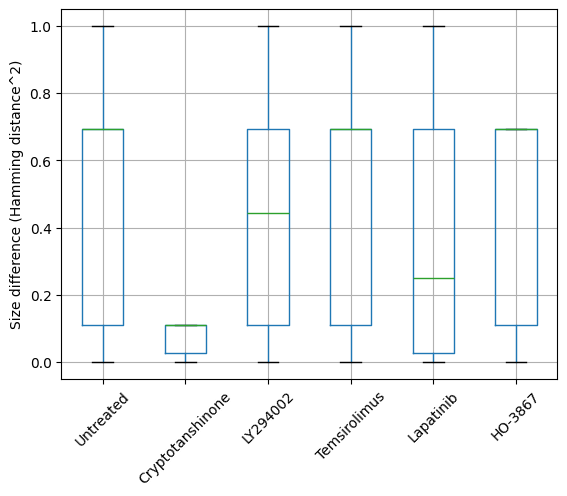

In [67]:
size_difference_single_drug = pd.DataFrame(size_difference_single_drug)
ax = size_difference_single_drug.boxplot()
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Size difference (Hamming distance^2)')


Text(0, 0.5, 'Size difference (Hamming distance^2)')

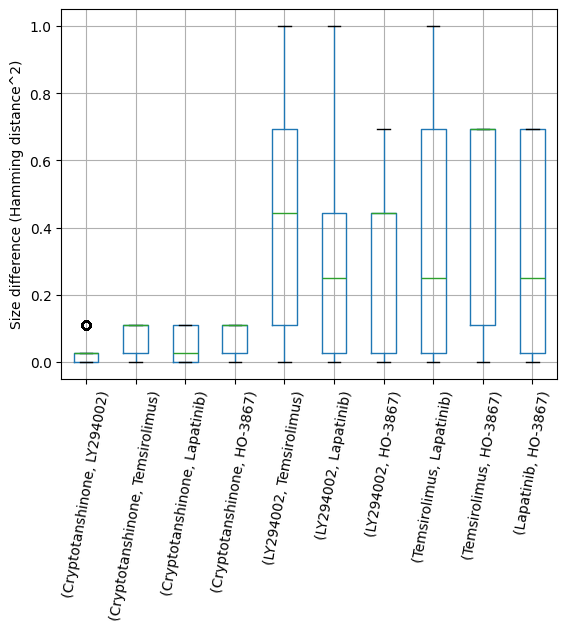

In [70]:
size_difference_double_drug = pd.DataFrame(size_difference_double_drug)
ax = size_difference_double_drug.boxplot()
ax.tick_params(axis='x', rotation=80)
ax.set_ylabel('Size difference (Hamming distance^2)')


These results are virtually identical to the results shown in Figure 5 of the paper.

## Scratch

In [21]:
network.knockout('GSK3', 0)
results = network.update(10)
output = [results[-1, network.nodeDict[k]] for k in output_genes]
output

[1, 0, 0, 0, 0, 0]

In [ ]:
network.undoKnockouts()
network.knockout('ERK1_2', 1)
results = network.update(27)
output = [results[-1, network.nodeDict[k]] for k in output_genes]
output

Note: I'm not sure I understand the paper, and I'm not sure if the paper does what I think it's doing. Most of the mutations are stuck at 0 mutations, and the outputs are mostly produced by AND gates, so most mutations will still leave the outputs at 0, same as the baseline/WT case. This seems to contradict what the paper shows, unless I'm misunderstanding things entirely?

Is the "size difference" calculated over just the output nodes, or is it calculated over every node in the network? Also, 

In [5]:
genes = 'ARID1A, CDKN2A, EP300, FAM123B, FBXW7, KDM6A, KRAS, MAP2K4, MLL3, PBRM1, RB1, RNF43, SACS, SMAD4, TP53'.split(', ')

In [6]:
genes

['ARID1A',
 'CDKN2A',
 'EP300',
 'FAM123B',
 'FBXW7',
 'KDM6A',
 'KRAS',
 'MAP2K4',
 'MLL3',
 'PBRM1',
 'RB1',
 'RNF43',
 'SACS',
 'SMAD4',
 'TP53']

In [8]:
for g in genes:
    print(g, g in network.nodeDict)

ARID1A False
CDKN2A False
EP300 False
FAM123B False
FBXW7 False
KDM6A False
KRAS False
MAP2K4 False
MLL3 False
PBRM1 False
RB1 False
RNF43 False
SACS False
SMAD4 False
TP53 False
